# Időjárás előrejelzés neurális hálóval
Beolvassuk az elmúlt 5-6 év hőmérséklet értékeit, előrecsatolt neurális hálóval keras segítségével görbét illesztünk rá és az alapján jósoljuk meg a várható értékeket

## Szükséges csomagok betöltése
### keras, numpy, matplotlib, datetime

In [1]:
# Először is, az egymáshoz képest lineárisan elhelyezkedő neurális hálózat modelljét.
from keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from keras.layers.core import Dense, Activation
# EarlyStopping a túltanulás ellen
from keras.callbacks import EarlyStopping
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt
%matplotlib inline

# Dátum manipulációk
from datetime import datetime, timedelta
#Copy for deepcopy
import copy

#URL-ből kapott szöveg formázása
import urllib
from bs4 import BeautifulSoup
import re

Using Theano backend.


### A program során használt segédfüggvények definiálása

In [2]:
def x_from_date(date):
    """Split the date, generating input"""
    d0= datetime.strptime("1900-1-1", "%Y-%m-%d")
    x=[]
    x.append(date.year)
    x.append(date.month)
    x.append(date.day)
    x.append((date-d0).days)
    return x

#Dataset specific functions
def x_from_data(data):
    """Split the first column of the data text as date"""
    x=np.array(x_from_date(data[0]),"float32")
    return x
def y_from_data(data):
    """Generate output from the last two column of the data text"""
    y=np.array([data[1],data[2]],"float32")
    return y
#Normalization functions
def x_norm(date,Av,std):
    """Normalize the x 1D input array"""
    date = (date-Av)/std
    return date
def y_norm_inv(temp,Av_y,std_y):
    """Recover the y 1D output array"""
    temp = temp*std_y+Av_y
    return temp

### EarlyStopping keras callback felüldefiniálása
 Az óraihoz hasonló loss-diagrammok ábrázolásához és a túltanulás ellen

In [3]:
class TrainingHistory(EarlyStopping):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon. 
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon. 
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 1 == 0:
            self.losses.append(logs.get('loss'))
            self.valid_losses.append(logs.get('val_loss'))
            self.accs.append(logs.get('acc'))
            self.valid_accs.append(logs.get('val_acc'))
            self.epoch += 1

## Adatok beolvasása, előkészítése

### Beolvasás URL-ből

In [4]:
url = "http://idojarasbudapest.hu/archivalt-idojaras"
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html)

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()
data3 = []

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)



## Formázás egy 1D tömbbe
for line in text.splitlines():
    line = re.sub('[^- \d\n]+','',line)
    if(re.match("\d+-\d+-\d+",line)):
        data3.append(line)

## Formázás egy 2D tömbbe      
data4 =[]
for line in data3:
    data4.append(line.split("  "))

/usr/lib/python3/dist-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [5]:
data2=data4
#Adatok beolvasása
#with open("temp.txt") as f:
#    data=f.read().split("\n")

#;-k mentén elvágás
#for d in data:
#    data2.append(d.split(";"))
#első oszlopból dátum
for i in range(len(data2)-1):
    data2[i][0]=datetime.strptime(data2[i][0], "%Y-%m-%d")
#Tanítási adatok előállítása
Xx = []
Yy = []
for i in range(len(data2)-1):
    Xx.append(x_from_data(data2[i]))
    Yy.append(y_from_data(data2[i]))

Xh = np.array(Xx)
Yh = np.array(Yy)
print("X, Y:")
print(Xh)
print(Yh,"\n")

#Normalizálás
Xh_norm = copy.deepcopy(Xh)
Yh_norm = copy.deepcopy(Yh)
Av=np.average(Xh,0)
Av_y=np.average(Yh,0)

std=np.std(Xh,0)
std_y=np.std(Yh,0)
print("Average of X:",Av,"\nStandard deviation in X:",std)
print("Average of Y:",Av_y,"\nStandard deviation in Y:",std_y)

for i in range(len(Xh_norm)):
    Xh_norm[i]=(Xh_norm[i]-Av)/std
    Yh_norm[i]=(Yh_norm[i]-Av_y)/std_y


#Xh_norm = Xh_norm[:,[0,1,2,3]]


print("Data size:{0}\n".format(len(Xh_norm)))
#Yh_norm=Yh_norm[:,[0,1]]

print("Xh_norm, Yh_norm:")
print(Xh_norm)
print(Yh_norm)

X, Y:
[[  2.01600000e+03   1.00000000e+01   2.90000000e+01   4.26700000e+04]
 [  2.01600000e+03   1.00000000e+01   2.80000000e+01   4.26690000e+04]
 [  2.01600000e+03   1.00000000e+01   2.70000000e+01   4.26680000e+04]
 ..., 
 [  2.01100000e+03   1.00000000e+01   2.00000000e+00   4.08160000e+04]
 [  2.01100000e+03   1.00000000e+01   1.00000000e+00   4.08150000e+04]
 [  2.01100000e+03   9.00000000e+00   3.00000000e+01   4.08140000e+04]]
[[ 15.   6.]
 [ 13.   6.]
 [ 12.   7.]
 ..., 
 [ 27.  10.]
 [ 25.  11.]
 [ 25.  10.]] 

Average of X: [  2.01378748e+03   6.56841516e+00   1.57306652e+01   4.17441641e+04] 
Standard deviation in X: [   1.49407852    3.44982576    8.7971611   535.8828125 ]
Average of Y: [ 17.39156342   8.10708523] 
Standard deviation in Y: [ 10.58782005   7.53577042]
Data size:1849

Xh_norm, Yh_norm:
[[ 1.48086226  0.99471253  1.50836551  1.72768354]
 [ 1.48086226  0.99471253  1.39469254  1.72581756]
 [ 1.48086226  0.99471253  1.28101945  1.72395146]
 ..., 
 [-1.86568213 

## Modell felépítése
4 input, két 10-es réteg, majd 2 output

In [6]:
# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely négy bemenetről kapja az adatokat.
model.add(Dense(output_dim=10, input_dim=4))
# A rétegen alkalmazott szigmoid aktivációs függvény.
model.add(Activation("sigmoid"))
# 2. réteg definiálása, amelynek 10 kimenete van.
model.add(Dense(output_dim=10))
# A rétegen alkalmazott szigmoid aktivációs függvény.
model.add(Activation("sigmoid"))
# Utolsó réteg definiálása, amelynek két kimenete van.
model.add(Dense(output_dim=2))
# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(lr=0.03, momentum=0.5, nesterov=False),
              metrics=['accuracy'])

### Tanítási és validációs adatok szétválasztása

In [7]:
#Validációs adatráta
valid_rate=0.1
tr_set_tmp = []
tr_vals_tmp = []
val_set_tmp = []
val_vals_tmp = []
#Random kiválasztunk a ráta arányában validációs adatokat
for i in range(0,len(Xh_norm)):
    if(np.random.random()-valid_rate)<0:
        val_set_tmp.append(Xh_norm[i])
        val_vals_tmp.append(Yh_norm[i])
    else:
        tr_set_tmp.append(Xh_norm[i])
        tr_vals_tmp.append(Yh_norm[i])

tr_set = np.array(tr_set_tmp, dtype= "float32")
tr_vals = np.array(tr_vals_tmp, dtype= "float32")
val_set = np.array(val_set_tmp, dtype= "float32")
val_vals = np.array(val_vals_tmp, dtype= "float32")
print("Training data size:")
print(np.shape(tr_set))
print("Validation data size:")
print(np.shape(val_set))

Training data size:
(1653, 4)
Validation data size:
(196, 4)


## Tanítás EarlyStopping segítségével

In [8]:
#EarlyStopping callback a túltanulás és a grafikonok kedvéért
early_stopping = TrainingHistory(monitor='valid_loss', patience=10, verbose=1, mode='auto')

In [9]:
#tanítás
model.fit(tr_set,
          # majd a kimenő adatokat.
          tr_vals,
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=14,
          # Tanulási fázisok száma.
          nb_epoch=10000,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Hamis értékre azért volt szükség, hogy a tanulási folyamatot felgyorsítsuk. 
          verbose=0, 
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(val_set, val_vals), 
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[early_stopping], 
          # A bemenő adatokat ne keverje meg a program, a napok sorrendje számít.
          shuffle= False)

### A tanulás folyamatának vizualizálása

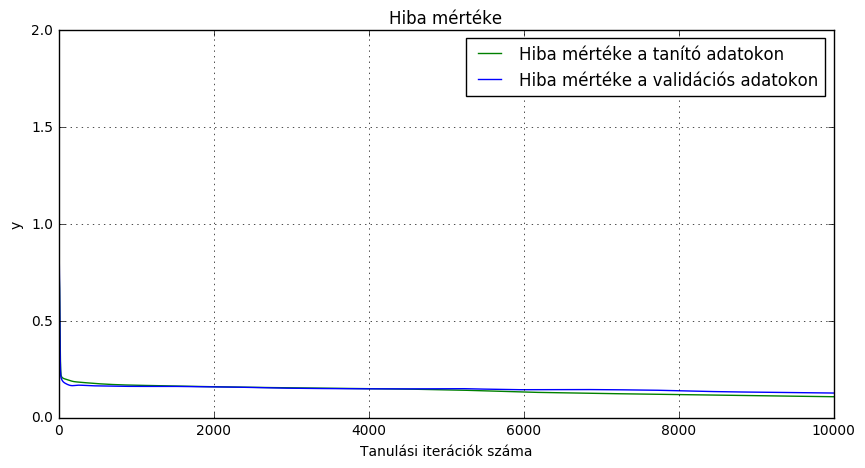

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(early_stopping.epoch), early_stopping.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(early_stopping.epoch), early_stopping.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

### Vizualizáció a teljes adathalmazra illesztett predikcióval

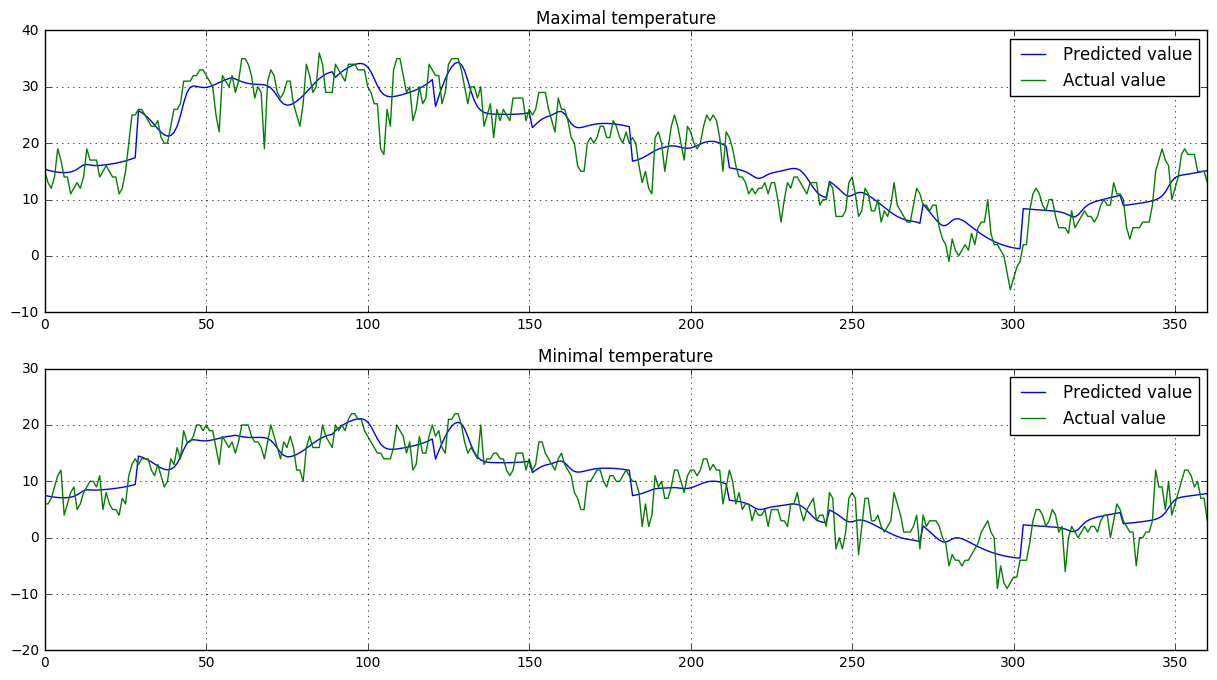

In [11]:
plt.figure(figsize=(15, 8))
pred_res_arr = model.predict(Xh_norm, batch_size=14, verbose=0)
pred_res_arr=pred_res_arr*std_y+Av_y
plt.subplot(2,1,1)
plt.title("Maximal temperature")
plt.plot(pred_res_arr[:,0],label="Predicted value")
plt.plot(Yh[:,0],label="Actual value")
plt.axis([0,360,None,None])
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,1,2)
plt.title("Minimal temperature")
plt.plot(pred_res_arr[:,1],label="Predicted value")
plt.plot(Yh[:,1],label="Actual value")
plt.axis([0,360,None,None])
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Előrejelzések

### Napi

In [12]:
#A mai nap
date_now = x_from_date(datetime.today())
#Normalizálva a tanító adatok értékeivel
date_now_norm=(date_now-Av)/std
# A hálózat becslésének beállításai
pred_res = model.predict(np.array([date_now_norm]), batch_size=4, verbose=0)
#Kimenet visszaalakítása
pred_res=pred_res*std_y+Av_y

print("Date: {:%Y-%m-%d} \nMaximal temperature: {:.3f} Minimal temperature: {:.3f}"
      .format(datetime.today(),pred_res[0][0],pred_res[0][1]))

Date: 2016-10-29 
Maximal temperature: 15.385 Minimal temperature: 7.517


### Heti

In [13]:
date_week = []
date = datetime.today()
date_week.append(x_from_date(date))
for i in range(1,7):
    date += timedelta(days=1)
    date_week.append(x_from_date(date))
date_week_norm = []
for i in range(len(date_week)):
    date_week_norm.append(x_norm(date_week[i],Av,std))

In [14]:
pred_res = model.predict(np.array(date_week_norm), batch_size=7, verbose=0)
for i in range(len(pred_res)):
    pred_res[i]=y_norm_inv(pred_res[i],Av_y,std_y)
    
date_iter = datetime.today()
for i in range(len(pred_res)):
    print("Date: {:%Y-%m-%d}, Max: {:.2f}, Min: {:.2f}".format(date_iter,pred_res[i][0],pred_res[i][1]))
    date_iter+=timedelta(days=1)

Date: 2016-10-29, Max: 15.39, Min: 7.52
Date: 2016-10-30, Max: 15.63, Min: 7.69
Date: 2016-10-31, Max: 15.95, Min: 7.90
Date: 2016-11-01, Max: 15.01, Min: 7.78
Date: 2016-11-02, Max: 14.97, Min: 7.75
Date: 2016-11-03, Max: 14.93, Min: 7.72
Date: 2016-11-04, Max: 14.89, Min: 7.69


## Havi

In [24]:
date_month = []
date = datetime.today()
date_month.append(x_from_date(date))
for i in range(1,30):
    date += timedelta(days=1)
    date_month.append(x_from_date(date))

In [25]:
date_month_norm = []
for i in range(len(date_month)):
    date_month_norm.append(x_norm(date_month[i],Av,std))

In [26]:
pred_res = model.predict(np.array(date_month_norm), batch_size=7, verbose=0)
for i in range(len(pred_res)):
    pred_res[i]=y_norm_inv(pred_res[i],Av_y,std_y)
date_iter = datetime.today()
for i in range(len(pred_res)):
    print("Date: {:%Y-%m-%d}, Max: {:.2f}, Min: {:.2f}".format(date_iter,pred_res[i][0],pred_res[i][1]))
    date_iter+=timedelta(days=1)

Date: 2016-10-29, Max: 15.39, Min: 7.52
Date: 2016-10-30, Max: 15.63, Min: 7.69
Date: 2016-10-31, Max: 15.95, Min: 7.90
Date: 2016-11-01, Max: 15.01, Min: 7.78
Date: 2016-11-02, Max: 14.97, Min: 7.75
Date: 2016-11-03, Max: 14.93, Min: 7.72
Date: 2016-11-04, Max: 14.89, Min: 7.69
Date: 2016-11-05, Max: 14.85, Min: 7.67
Date: 2016-11-06, Max: 14.82, Min: 7.64
Date: 2016-11-07, Max: 14.79, Min: 7.62
Date: 2016-11-08, Max: 14.76, Min: 7.60
Date: 2016-11-09, Max: 14.73, Min: 7.58
Date: 2016-11-10, Max: 14.71, Min: 7.56
Date: 2016-11-11, Max: 14.69, Min: 7.54
Date: 2016-11-12, Max: 14.69, Min: 7.52
Date: 2016-11-13, Max: 14.70, Min: 7.51
Date: 2016-11-14, Max: 14.72, Min: 7.46
Date: 2016-11-15, Max: 14.61, Min: 7.28
Date: 2016-11-16, Max: 14.20, Min: 6.84
Date: 2016-11-17, Max: 13.54, Min: 6.23
Date: 2016-11-18, Max: 12.91, Min: 5.67
Date: 2016-11-19, Max: 12.46, Min: 5.28
Date: 2016-11-20, Max: 12.18, Min: 5.05
Date: 2016-11-21, Max: 12.01, Min: 4.91
Date: 2016-11-22, Max: 11.91, Min: 4.82


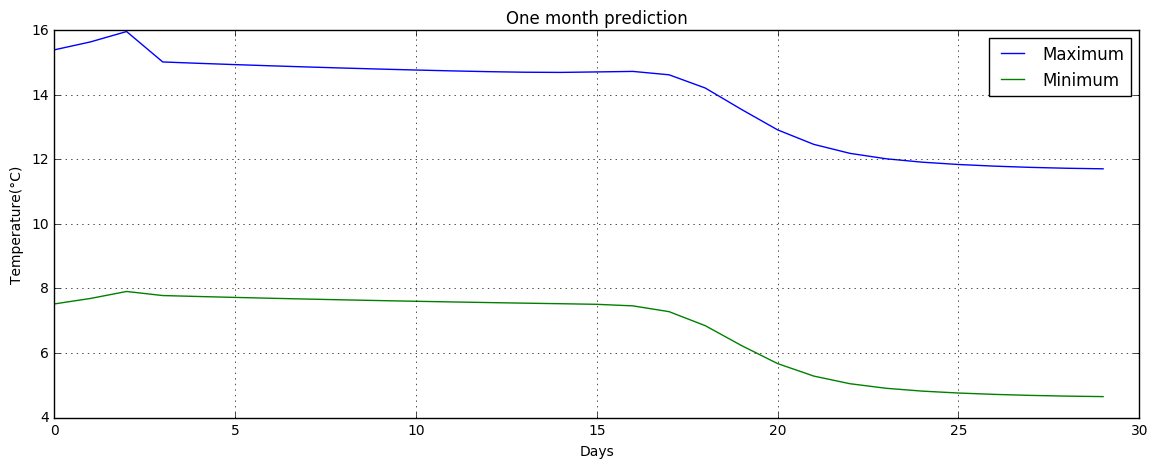

In [27]:
plt.figure(figsize=(14, 5))
plt.title('One month prediction')
plt.plot(pred_res[:,0],label="Maximum") 
plt.plot(pred_res[:,1],label="Minimum")
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Temperature(°C)')
plt.grid(True)
plt.show()